<h1> Health care database analysis with Spark </h1>

The goal is to access a dataset through Spark and train a Machine Learning model.

We want to identify the different features that have the greatest impact on the risk of a heart attack.

Summary :
- Data Analysis
- Data processing
- Logistic Regression
- Random Forest
- XGBoost
- Conclusion

Spoiler alert : the database is not big enough to train effectively a model.

First, let's reach the heart-attack-analysis-prediction-dataset available on Kaggle

In [1]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 12.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=1a8f25f8a7d5f1694144b3cca26c3e8683b06b223b5fad30d6a20e9ff4384c44
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [2]:
import kagglehub
from pyspark.sql import SparkSession
import os

# Download dataset
path = kagglehub.dataset_download("iamsouravbanerjee/heart-attack-prediction-dataset") #8700 elements
#path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")  #5110 elements
print("Path to dataset files:", path)

heart_csv_path = os.path.join(path, "heart_attack_prediction_dataset.csv")
#heart_csv_path = os.path.join(path, "healthcare-dataset-stroke-data.csv")

# Create Spark session
spark = SparkSession.builder.appName('Heart_attack_analysis').getOrCreate()

# Load the CSV into a DataFrame
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(heart_csv_path)

# Show the first few rows
df.show()
df.printSchema()


100%|██████████| 519k/519k [00:00<00:00, 85.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/iamsouravbanerjee/heart-attack-prediction-dataset/versions/2


+----------+---+------+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-----------------------+------+------------------+-------------+-------------------------------+-------------------+-------------+-------------+-------------------+-----------------+
|Patient ID|Age|   Sex|Cholesterol|Blood Pressure|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|     Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|Income|               BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|      Country|    Continent|         Hemisphere|Heart Attack Risk|
+----------+---+------+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-------------

<h1> Data Analysis </h1>

In [3]:
from pyspark.sql.functions import col, when, count

columns = df.columns
print(columns, len(columns))

['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country', 'Continent', 'Hemisphere', 'Heart Attack Risk'] 26


In [4]:
from functools import reduce
# Check for null values in each column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

missing_count = df.filter(
    reduce(lambda x, y: x | y, (col(c).isNull() for c in df.columns))
).count()

if missing_count == 0:
    print("No missing values in the dataset!")
else:
    print(f"Dataset contains {missing_count} rows with missing values.")

+----------+---+---+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+----+-----------------------+--------------+------------+-----------------------+------+---+-------------+-------------------------------+-------------------+-------+---------+----------+-----------------+
|Patient ID|Age|Sex|Cholesterol|Blood Pressure|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|Income|BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|Country|Continent|Hemisphere|Heart Attack Risk|
+----------+---+---+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+----+-----------------------+--------------+------------+-----------------------+------+---+-------------+-------------------------------+-------------------+----

In [5]:
row_count = df.count()
# Print the result
print(f"Number of rows: {row_count}")

Number of rows: 8763


In [6]:
df.groupBy("Heart Attack Risk").count().show()
df.groupBy("Sex").count().show()
df.groupBy("Diabetes").count().show()
df.groupBy("Smoking").count().show()
df.groupBy("Hemisphere").count().show()

+-----------------+-----+
|Heart Attack Risk|count|
+-----------------+-----+
|                1| 3139|
|                0| 5624|
+-----------------+-----+

+------+-----+
|   Sex|count|
+------+-----+
|Female| 2652|
|  Male| 6111|
+------+-----+

+--------+-----+
|Diabetes|count|
+--------+-----+
|       1| 5716|
|       0| 3047|
+--------+-----+

+-------+-----+
|Smoking|count|
+-------+-----+
|      1| 7859|
|      0|  904|
+-------+-----+

+-------------------+-----+
|         Hemisphere|count|
+-------------------+-----+
|Northern Hemisphere| 5660|
|Southern Hemisphere| 3103|
+-------------------+-----+



In [7]:
df.describe(['Age', 'BMI', 'Income']).show()

+-------+------------------+------------------+------------------+
|summary|               Age|               BMI|            Income|
+-------+------------------+------------------+------------------+
|  count|              8763|              8763|              8763|
|   mean| 53.70797672030127|28.891445877259645|158263.18190117538|
| stddev|21.249508802215995| 6.319181335543785| 80575.19080559714|
|    min|                18|18.002336577801902|             20062|
|    max|                90| 39.99721081557256|            299954|
+-------+------------------+------------------+------------------+



In [8]:
from pyspark.sql.functions import when, col

# Define age bins and create a new column for age groups
df_with_age_groups = df.withColumn(
    "age_group",
    when((col("Age") >= 18) & (col("Age") <= 28), "18-25")
    .when((col("Age") > 28) & (col("Age") <= 38), "25-35")
    .when((col("Age") > 38) & (col("Age") <= 48), "35-45")
    .when((col("Age") > 48) & (col("Age") <= 58), "45-55")
    .when((col("Age") > 58) & (col("Age") <= 68), "55-65")
    .when((col("Age") > 68) & (col("Age") <= 78), "65-75")
    .when((col("Age") > 78) & (col("Age") <= 88), "75-85")
    .when((col("Age") > 88) & (col("Age") <= 98), "85-95")
    .otherwise("95+")
)

# Group by age group and count the number of patients in each group
age_group_counts = df_with_age_groups.groupBy("age_group").count().orderBy("age_group")
age_group_counts.show()


+---------+-----+
|age_group|count|
+---------+-----+
|    18-25| 1365|
|    25-35| 1262|
|    35-45| 1183|
|    45-55| 1127|
|    55-65| 1231|
|    65-75| 1136|
|    75-85| 1190|
|    85-95|  269|
+---------+-----+



<h2> Age influence </h2>

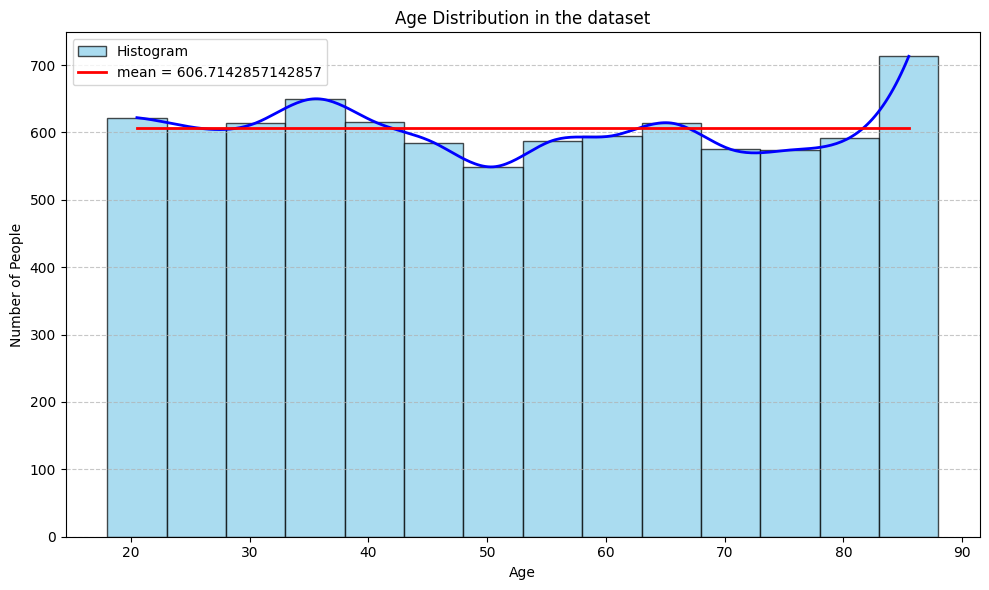

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Convert Age column to Pandas
ages_pdf = df.select("Age").toPandas()

# Create histogram bins
bins = range(18, 90, 5)  # Grouping ages into bins of 5 years
hist_values, bin_edges = np.histogram(ages_pdf["Age"], bins=bins)

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 300)  # Create smooth x-axis points
spline = make_interp_spline(bin_centers, hist_values, k=3)  # Spline interpolation of degree 3
y_smooth = spline(x_smooth)  # Generate smooth y-axis points

y_mean = [np.mean(hist_values) for i in range(len(x_smooth))]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(ages_pdf["Age"], bins=bins, color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')

# Plot the smooth red line and mean
plt.plot(x_smooth, y_smooth, color='blue', linewidth=2)
plt.plot(x_smooth, y_mean, color='red', linewidth=2, label=f'mean = {y_mean[0]}')

# Add labels and title
plt.xlabel("Age")
plt.ylabel("Number of People")
plt.title("Age Distribution in the dataset")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


We clearly see here the age range of the patients from whom the data was collected is remarkably broad, encompassing individuals from all age groups. This diversity ensures comprehensive representation across different age brackets, making the dataset well-suited for inclusive analysis.



In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from pyspark.sql.functions import col
from ipywidgets import interact, IntSlider

# This function will be called by the interactive widget
def update_plot(alpha):
    # Update dataset with new age groups based on alpha
    result = df.withColumn("age_group", (col("Age") / alpha).cast("int") * alpha) \
               .groupBy("age_group").avg("Heart Attack Risk").orderBy("age_group")
    result = result.toPandas()

    # Compute histogram values and edges
    hist_values, bin_edges = np.histogram(result['age_group'], bins=len(result['age_group']))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Interpolate a smooth curve
    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 300)
    spline = make_interp_spline(bin_centers, result['avg(Heart Attack Risk)'], k=3)  # Use bin_centers here
    y_smooth = spline(x_smooth)
    y_mean = [np.mean(result['avg(Heart Attack Risk)']) for i in range(len(x_smooth))]

    # Clear the current plot and re-draw
    plt.clf()
    plt.hist(result['age_group'], weights=result['avg(Heart Attack Risk)'],
             bins=len(result['age_group']), color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')
    plt.plot(x_smooth, y_smooth, color='blue', linewidth=2)
    plt.plot(x_smooth, y_mean, color='red', linewidth=2, label=f'Mean {y_mean[0]}')
    plt.xlabel("Age Group")
    plt.ylabel("Average Heart Attack Risk")
    plt.title(f"Heart Attack Risk by Age Group (Alpha={alpha})")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()  # Display the plot

# Create an interactive slider using ipywidgets
interact(update_plot, alpha=IntSlider(min=2, max=20, step=1, value=10))

interactive(children=(IntSlider(value=10, description='alpha', max=20, min=2), Output()), _dom_classes=('widge…

<function __main__.update_plot(alpha)>

According to the dataset, there is less risk to be victim of a heart attack before 20 but then the risk is the same in each age group.

<h2> Gender influence </h2>

+------+-----+
|   Sex|count|
+------+-----+
|Female| 2652|
|  Male| 6111|
+------+-----+



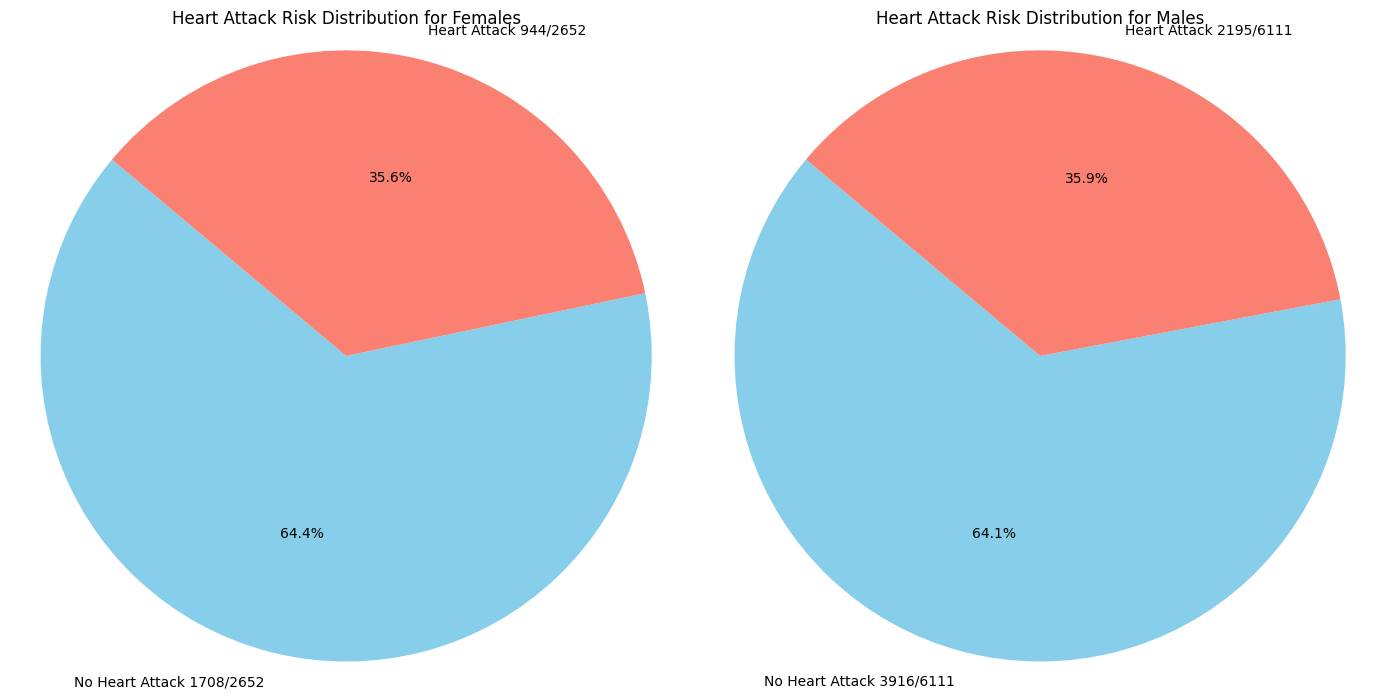

In [11]:
import matplotlib.pyplot as plt

df.groupBy("Sex").count().show()


# Filter for females in the dataset
female_data = df.filter(col("Sex") == 'Female')
female_counts = (
    female_data.groupBy("Heart Attack Risk")
    .count()
    .toPandas()
    .sort_values("Heart Attack Risk")
)

# Filter for males in the dataset
male_data = df.filter(col("Sex") == 'Male')
male_counts = (
    male_data.groupBy("Heart Attack Risk")
    .count()
    .toPandas()
    .sort_values("Heart Attack Risk")
)

# Prepare data for females
female_labels = [
    f"No Heart Attack {female_counts.values[0][1]}/{female_counts['count'].sum()}",
    f"Heart Attack {female_counts.values[1][1]}/{female_counts['count'].sum()}"
]
female_sizes = female_counts["count"].values
colors = ["skyblue", "salmon"]

# Prepare data for males
male_labels = [
    f"No Heart Attack {male_counts.values[0][1]}/{male_counts['count'].sum()}",
    f"Heart Attack {male_counts.values[1][1]}/{male_counts['count'].sum()}"
]
male_sizes = male_counts["count"].values

# Plot the pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Female pie chart
axes[0].pie(female_sizes, labels=female_labels, autopct="%1.1f%%", colors=colors, startangle=140)
axes[0].set_title("Heart Attack Risk Distribution for Females")
axes[0].axis("equal")  # Equal aspect ratio ensures the pie is circular.

# Male pie chart
axes[1].pie(male_sizes, labels=male_labels, autopct="%1.1f%%", colors=colors, startangle=140)
axes[1].set_title("Heart Attack Risk Distribution for Males")
axes[1].axis("equal")  # Equal aspect ratio ensures the pie is circular.

# Display the plots
plt.tight_layout()
plt.show()


In this dataset, male and female have equal chance to have a heart attack.

However the number of males is higher than the number of female patients in the dataset so we need to consider this before applying a machine learning model.

<h2>Tobacco influence</h2>

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from pyspark.sql.functions import col
from ipywidgets import interact, IntSlider

# This function will be called by the interactive widget
def update_plot(alpha):
    # Update dataset with new age groups based on alpha
    result = df.withColumn("age_group", (col("Age") / alpha).cast("int") * alpha) \
               .groupBy("age_group").avg("Smoking").orderBy("age_group")
    result = result.toPandas()

    # Compute histogram values and edges
    hist_values, bin_edges = np.histogram(result['age_group'], bins=len(result['age_group']))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Interpolate a smooth curve
    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 300)
    spline = make_interp_spline(bin_centers, result['avg(Smoking)'], k=3)  # Use bin_centers here
    y_smooth = spline(x_smooth)
    y_mean = [np.mean(result['avg(Smoking)']) for i in range(len(x_smooth))]

    # Clear the current plot and re-draw
    plt.clf()
    plt.hist(result['age_group'], weights=result['avg(Smoking)'],
             bins=len(result['age_group']), color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')
    plt.plot(x_smooth, y_smooth, color='blue', linewidth=2)
    plt.plot(x_smooth, y_mean, color='red', linewidth=2, label=f'Mean {y_mean[0]}')
    plt.xlabel("Age Group")
    plt.ylabel("Average Smoking")
    plt.title(f"Tobacco use by Age Group (Alpha={alpha})")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()  # Display the plot

# Create an interactive slider using ipywidgets
interact(update_plot, alpha=IntSlider(min=2, max=20, step=1, value=10))

interactive(children=(IntSlider(value=10, description='alpha', max=20, min=2), Output()), _dom_classes=('widge…

<function __main__.update_plot(alpha)>

We can see that there are more smokers beyond the age 40.

+-------+-----+
|Smoking|count|
+-------+-----+
|      1| 7859|
|      0|  904|
+-------+-----+



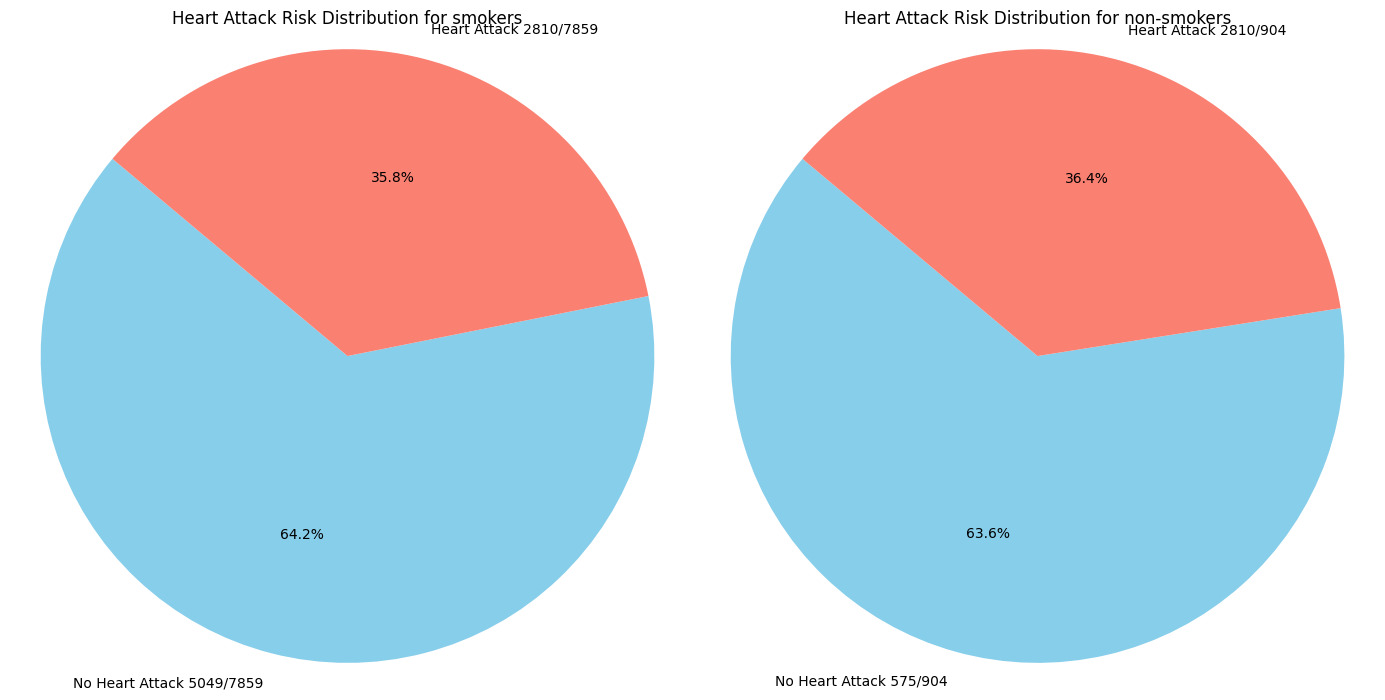

In [13]:
import matplotlib.pyplot as plt

df.groupBy("Smoking").count().show()


# Filter for smokers in the dataset
smokers_data = df.filter(col("Smoking") == '1')
smokers_counts = (
    smokers_data.groupBy("Heart Attack Risk")
    .count()
    .toPandas()
    .sort_values("Heart Attack Risk")
)

nonsmokers_data = df.filter(col("Smoking") == '0')
nonsmokers_counts = (
    nonsmokers_data.groupBy("Heart Attack Risk")
    .count()
    .toPandas()
    .sort_values("Heart Attack Risk")
)

colors = ["skyblue", "salmon"]

# Prepare data for males
smokers_labels = [
    f"No Heart Attack {smokers_counts.values[0][1]}/{smokers_counts['count'].sum()}",
    f"Heart Attack {smokers_counts.values[1][1]}/{smokers_counts['count'].sum()}"
]
smokers_sizes = smokers_counts["count"].values

nonsmokers_labels = [
    f"No Heart Attack {nonsmokers_counts.values[0][1]}/{nonsmokers_counts['count'].sum()}",
    f"Heart Attack {smokers_counts.values[1][1]}/{nonsmokers_counts['count'].sum()}"
]
nonsmokers_sizes = nonsmokers_counts["count"].values

# Plot the pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Smokers pie chart
axes[0].pie(smokers_sizes, labels=smokers_labels, autopct="%1.1f%%", colors=colors, startangle=140)
axes[0].set_title("Heart Attack Risk Distribution for smokers")
axes[0].axis("equal")  # Equal aspect ratio ensures the pie is circular.

# Non-smokers pie chart
axes[1].pie(nonsmokers_sizes, labels=nonsmokers_labels, autopct="%1.1f%%", colors=colors, startangle=140)
axes[1].set_title("Heart Attack Risk Distribution for non-smokers")
axes[1].axis("equal")  # Equal aspect ratio ensures the pie is circular.

plt.tight_layout()
plt.show()

Although there is a strong correlation between age and smoking habits, with older patients tending to smoke more on average, there appears to be no clear correlation between smoking and the risk of being victim of a heart attack.

<h1> Correlation </h1>
First, let's see if there is any correlation between the heart attack event and any other feature in the dataset.

In [14]:
from pyspark.sql.functions import when, col, split

"""Encode all the string columns"""
#Old columns |Patient ID|Age|   Sex|Cholesterol|Blood Pressure|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|     Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|Income|               BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|      Country|    Continent|         Hemisphere|Heart Attack Risk|

# Add the encoded column for Sex
df_encoded = df.withColumn("Sex_encoded", when(col("Sex") == "Female", 0).otherwise(1))
df_encoded = df_encoded.drop("Sex")

df_encoded = df_encoded.withColumn("Hemisphere_encoded", when(col("Hemisphere") == "Northern Hemisphere", 0).otherwise(1))
df_encoded = df_encoded.drop("Hemisphere")

df_encoded = df_encoded.withColumn("Diet_encoded", when(col("Diet") == "Unhealthy", 0).when(col("Diet") == "Average", 1).otherwise(2))
df_encoded = df_encoded.drop("Diet")

split_col = split(df_encoded['Blood Pressure'], '/')
df_encoded = df_encoded.withColumn('Systolic', split_col.getItem(0).cast("float")) \
                        .withColumn('Diastolic', split_col.getItem(1).cast("float")) \
                        .drop('Blood Pressure')

df_encoded = df_encoded.drop("Country")
df_encoded = df_encoded.drop("Continent")
df_encoded = df_encoded.drop("Patient ID")

# Display the updated DataFrame schema
df_encoded.printSchema()

# Optional: Show a preview of the updated DataFrame
df_encoded.show(5)


root
 |-- Age: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Family History: integer (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- Obesity: integer (nullable = true)
 |-- Alcohol Consumption: integer (nullable = true)
 |-- Exercise Hours Per Week: double (nullable = true)
 |-- Previous Heart Problems: integer (nullable = true)
 |-- Medication Use: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- Sedentary Hours Per Day: double (nullable = true)
 |-- Income: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Triglycerides: integer (nullable = true)
 |-- Physical Activity Days Per Week: integer (nullable = true)
 |-- Sleep Hours Per Day: integer (nullable = true)
 |-- Heart Attack Risk: integer (nullable = true)
 |-- Sex_encoded: integer (nullable = false)
 |-- Hemisphere_encoded: integer (nullable = false)
 |-- Diet_e

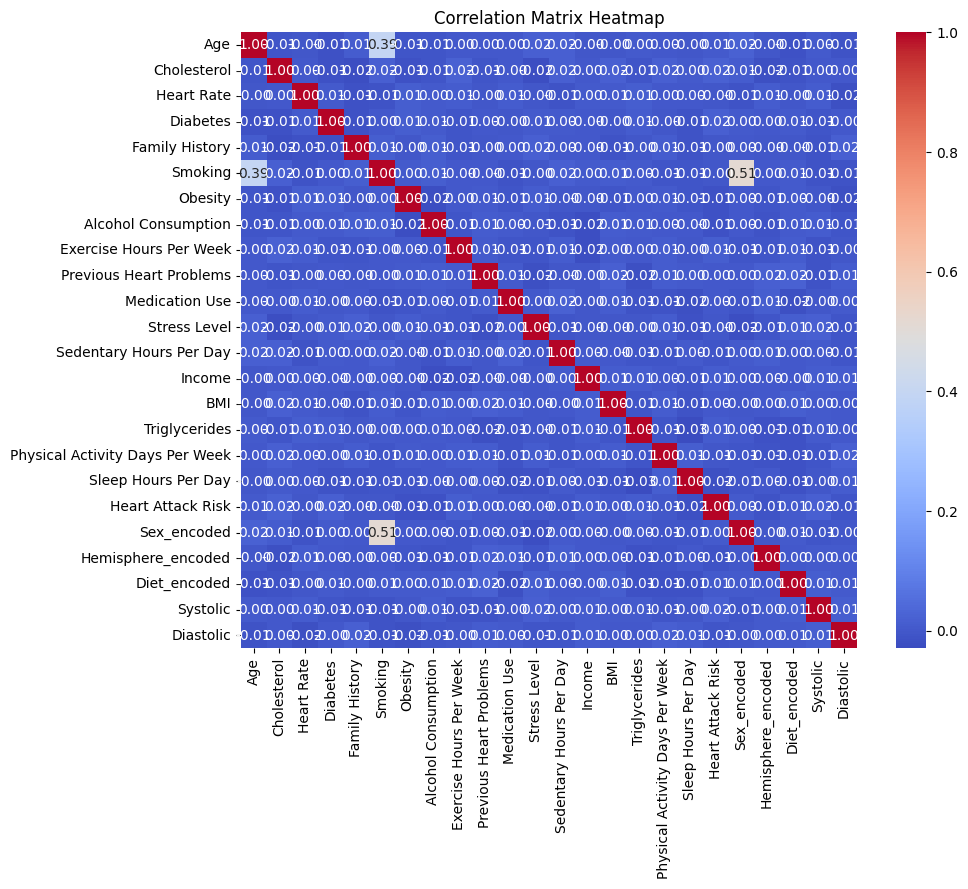

In [15]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define numeric columns and assemble features
numeric_cols = df_encoded.columns
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(df_encoded).select(vector_col)

# Compute correlation matrix
corr_matrix = Correlation.corr(df_vector, vector_col).head()[0].toArray()

# Convert to pandas DataFrame for better visualization
corr_df = pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()


In [16]:
df_encoded.groupBy("Heart Attack Risk").avg("Smoking", "Alcohol Consumption", "Obesity", "Age",
                                  "Cholesterol", "Diabetes", "Family History", "Diet_encoded", "Systolic", "Diastolic").show()

+-----------------+------------------+------------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-----------------+
|Heart Attack Risk|      avg(Smoking)|avg(Alcohol Consumption)|       avg(Obesity)|          avg(Age)|  avg(Cholesterol)|     avg(Diabetes)|avg(Family History)|avg(Diet_encoded)|     avg(Systolic)|   avg(Diastolic)|
+-----------------+------------------+------------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-----------------+
|                1|0.8951895508123606|       0.589041095890411|0.49251353934374004|53.890092386110226|261.97037273016883|0.6632685568652437|0.49187639375597325|1.014335775724753|135.73112456196242|85.00860146543485|
|                0|0.8977596017069701|      0.6031294452347084| 0.5064011379800853| 53.60633001422475| 258.7089260312944|0.6461593172119

<h2>Conclusion :</h2>

We understand that the Heart Attack Risk is not depending on one feature only.
The correlation matrix also confirms the conclusion on the transparent impact of tobacco on the "Heart Attack Risk" feature. None of the features could be used to conclude directly.

This is why it is interesting to create a machine model to understand the most affecting feature.  

<h1> Data processing by undersampling</h1>


First, we will recalibrate the number of positive "Heart Attack Risk" patients

In [17]:
df_1 = df_encoded.filter(col("Heart Attack Risk") == 1)
df_0 = df_encoded.filter(col("Heart Attack Risk") == 0)

print(f"Count of Heart Attack Risk = 1: {df_1.count()}")
print(f"Count of Heart Attack Risk = 0: {df_0.count()}")

# Get the count of Heart Attack Risk = 1
count_1 = df_1.count()

# # Undersample df_0 to have the same number of rows as df_1
df_0_undersampled = df_0.sample(False, count_1 / df_0.count(), seed=42)

# Combine the two datasets
balanced_df = df_1.union(df_0_undersampled)

# Show the result
print(f"Balanced dataset count: {balanced_df.count()}")

balanced_df.groupBy("Heart Attack Risk").count().show()
balanced_df.groupBy("Sex_encoded").count().show()
balanced_df.groupBy("Diabetes").count().show()
balanced_df.groupBy("Smoking").count().show()
balanced_df.groupBy("Hemisphere_encoded").count().show()

Count of Heart Attack Risk = 1: 3139
Count of Heart Attack Risk = 0: 5624
Balanced dataset count: 6331
+-----------------+-----+
|Heart Attack Risk|count|
+-----------------+-----+
|                1| 3139|
|                0| 3192|
+-----------------+-----+

+-----------+-----+
|Sex_encoded|count|
+-----------+-----+
|          1| 4408|
|          0| 1923|
+-----------+-----+

+--------+-----+
|Diabetes|count|
+--------+-----+
|       1| 4138|
|       0| 2193|
+--------+-----+

+-------+-----+
|Smoking|count|
+-------+-----+
|      1| 5686|
|      0|  645|
+-------+-----+

+------------------+-----+
|Hemisphere_encoded|count|
+------------------+-----+
|                 1| 2232|
|                 0| 4099|
+------------------+-----+



+-----------+-----+
|Sex_encoded|count|
+-----------+-----+
|          1| 4408|
|          0| 1923|
+-----------+-----+



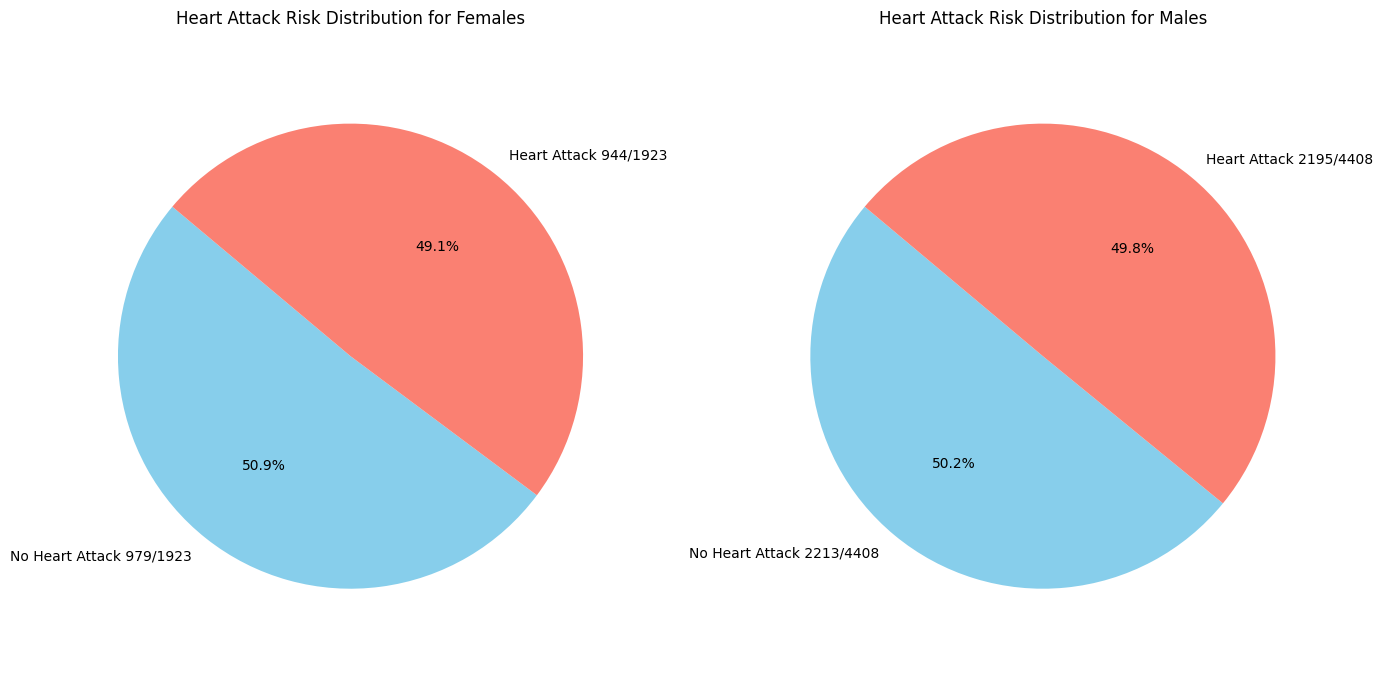

In [18]:
import matplotlib.pyplot as plt

balanced_df.groupBy("Sex_encoded").count().show()


# Filter for females in the dataset
female_data = balanced_df.filter(col("Sex_encoded") == 0)
female_counts = (
    female_data.groupBy("Heart Attack Risk")
    .count()
    .toPandas()
    .sort_values("Heart Attack Risk")
)

# Filter for males in the dataset
male_data = balanced_df.filter(col("Sex_encoded") == 1)
male_counts = (
    male_data.groupBy("Heart Attack Risk")
    .count()
    .toPandas()
    .sort_values("Heart Attack Risk")
)

# Prepare data for females
female_labels = [
    f"No Heart Attack {female_counts.values[0][1]}/{female_counts['count'].sum()}",
    f"Heart Attack {female_counts.values[1][1]}/{female_counts['count'].sum()}"
]
female_sizes = female_counts["count"].values
colors = ["skyblue", "salmon"]

# Prepare data for males
male_labels = [
    f"No Heart Attack {male_counts.values[0][1]}/{male_counts['count'].sum()}",
    f"Heart Attack {male_counts.values[1][1]}/{male_counts['count'].sum()}"
]
male_sizes = male_counts["count"].values

# Plot the pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Female pie chart
axes[0].pie(female_sizes, labels=female_labels, autopct="%1.1f%%", colors=colors, startangle=140)
axes[0].set_title("Heart Attack Risk Distribution for Females")
axes[0].axis("equal")  # Equal aspect ratio ensures the pie is circular.

# Male pie chart
axes[1].pie(male_sizes, labels=male_labels, autopct="%1.1f%%", colors=colors, startangle=140)
axes[1].set_title("Heart Attack Risk Distribution for Males")
axes[1].axis("equal")  # Equal aspect ratio ensures the pie is circular.

# Display the plots
plt.tight_layout()
plt.show()


<h1> Simple logistic regression using cross validation</h1>

We will create a pipeline based on a logistic regression to generate 5 models that we will train on the training dataset. Then we will keep the best model.

In [19]:
from pyspark.sql.functions import split, col
from pyspark.ml.feature import StringIndexer

feature_cols = ['Age', 'Sex_encoded', 'Cholesterol', 'Hemisphere_encoded', 'Diet_encoded', 'Systolic', 'Diastolic',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week',
       'Previous Heart Problems', 'Medication Use', 'Stress Level', 'BMI', 'Triglycerides','Heart Attack Risk'
       ]

data=balanced_df[feature_cols]

# Define features and target
X = data.drop('Heart Attack Risk')
y = balanced_df.select("Heart Attack Risk")

X_train, X_test = X.randomSplit([0.7, 0.3], seed=42)
y_train, y_test = y.randomSplit([0.7, 0.3], seed=42)
data_train, data_test = data.randomSplit([0.7, 0.3], seed=42)

In [20]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# VectorAssembler combines all the features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="Heart Attack Risk")
pipeline = Pipeline(stages=[assembler, lr])

In [22]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.1, 0.5, 1.0]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()  # Example values for elastic net (L1 + L2)

# Create a CrossValidator between 5 logistic regressions
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="Heart Attack Risk"),
                          numFolds=5)  # Use 5 folds for cross-validation

# Fit the model using CrossValidator
cvModel = crossval.fit(data_train)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Make predictions on test data
predictions = bestModel.transform(data_test)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy on test data: {accuracy}")

# Check coefficients of the best model
lr_model = bestModel.stages[-1]  # Assuming LogisticRegression is the last stage
coefficients = lr_model.coefficients
print("Coefficients:", coefficients)

# Print training accuracy (for comparison)
train_predictions = bestModel.transform(data_train)
train_accuracy = evaluator.evaluate(train_predictions)
print(f"Accuracy on training data: {train_accuracy}")

Accuracy on test data: 1.0
Coefficients: [0.0001399350209996955,0.02021647964564259,9.256491466271363e-05,-0.003282919650656533,0.004578246468670995,0.00020566524025388466,-0.00026243812247924624,5.472708539036199e-05,0.01210315283083674,0.003660727324595214,-0.0034680093337407943,-0.004477792516530425,-0.007483595795121787,0.0012097208883039608,-0.006928043269950461,0.001520958567248056,0.0007569517200987437,0.0003498677786309206,1.797777410279335e-05,37.912483574067]
Accuracy on training data: 1.0


Accuracy: 1.0
Area under ROC: 0.9999996028199781
Weighted Precision: 1.0
Weighted Recall: 1.0
Weighted F-Measure: <bound method _ClassificationSummary.weightedFMeasure of <pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary object at 0x7ec0d4f3d1b0>>


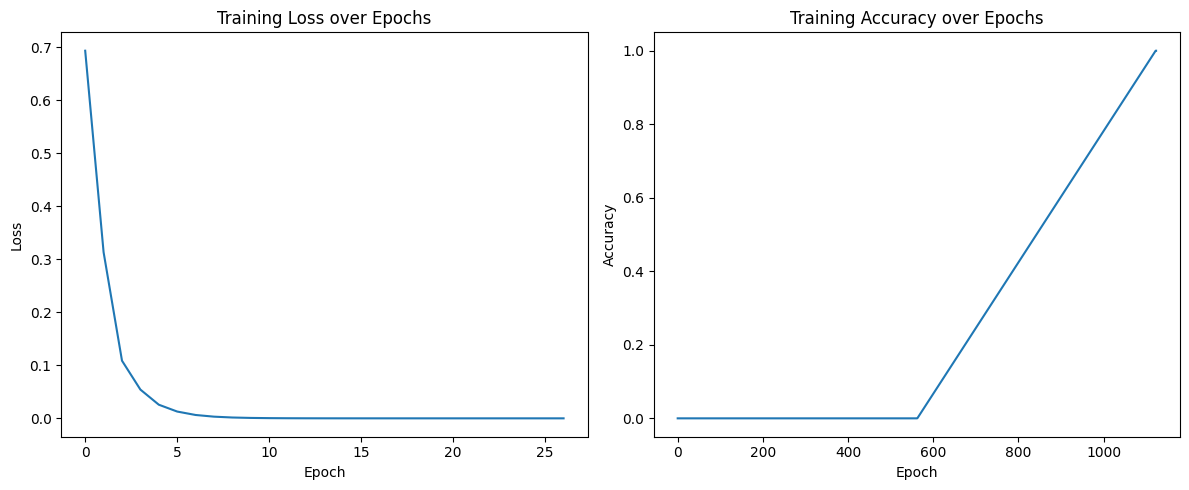

In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

trainingSummary = lr_model.summary

# Extract objective history (training loss) and accuracy history
objectiveHistory = trainingSummary.objectiveHistory
rocHistory = trainingSummary.roc.select("FPR").rdd.flatMap(lambda x: x).collect()

# Calculate metrics
evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")
print("Area under ROC: {0}".format(lr_model.summary.areaUnderROC))
print("Weighted Precision: {0}".format(lr_model.summary.weightedPrecision))
print("Weighted Recall: {0}".format(lr_model.summary.weightedRecall))
print("Weighted F-Measure: {0}".format(lr_model.summary.weightedFMeasure))

#Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(objectiveHistory)
axes[0].set_title("Training Loss over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

axes[1].plot(rocHistory)
axes[1].set_title("Training Accuracy over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

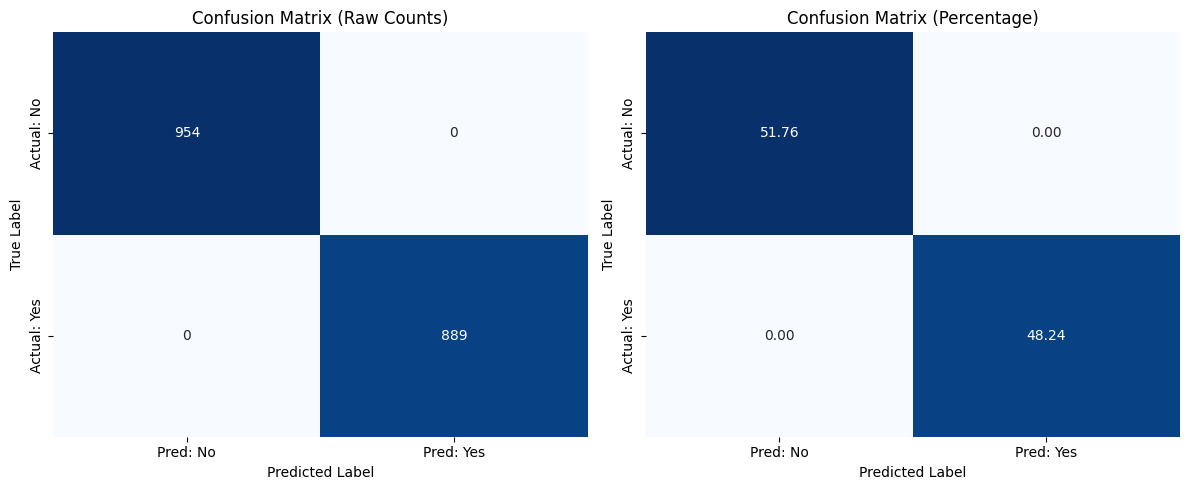

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

"""Confusion matrix"""

# Get predictions and labels
predictions_and_labels = predictions.select(col("Heart Attack Risk"), col("prediction"))

# Calculate confusion matrix elements
confusion_matrix = predictions_and_labels.groupBy("Heart Attack Risk", "prediction").count().toPandas()

# Prepare confusion matrix as a percentage
total_samples = confusion_matrix["count"].sum()
conf_matrix = np.zeros((2, 2))
conf_matrix_percent = np.zeros((2, 2))

for index, row in confusion_matrix.iterrows():
    actual = int(row["Heart Attack Risk"])
    predicted = int(row["prediction"])
    conf_matrix_percent[actual, predicted] = row["count"] / total_samples * 100
    conf_matrix[actual, predicted] = row["count"]

# Plot Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=False,
            xticklabels=["Pred: No", "Pred: Yes"], yticklabels=["Actual: No", "Actual: Yes"], ax=axes[0])
axes[0].set_title("Confusion Matrix (Raw Counts)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=["Pred: No", "Pred: Yes"], yticklabels=["Actual: No", "Actual: Yes"], ax=axes[1])
axes[1].set_title("Confusion Matrix (Percentage)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()



<h1> Conclusion : </h1>

We clearly see that the model is **overfitting**.
We will now try to train a random forest classifier as it is another simple model and we can adjust the depth of training (number of trees, depth of the trees, etc.)

<h1> Random forest classifier </h1>

In [25]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Select the features and the label
feature_columns = ["Age", "Cholesterol", "Heart Rate", "Diabetes", "Family History", "Smoking", "Obesity",
                   "Alcohol Consumption", "Exercise Hours Per Week", "Previous Heart Problems",
                   "Medication Use", "Stress Level", "BMI", "Triglycerides", "Systolic", "Diastolic", "Sex_encoded"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a Random Forest Classifier
rf = RandomForestClassifier(labelCol="Heart Attack Risk", featuresCol="features", numTrees=10, seed=42)
pipelinerf = Pipeline(stages=[assembler, rf])

# Train the model
model = pipelinerf.fit(data_train)

# Evaluate the model on test data
evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk", predictionCol="prediction", metricName="accuracy")
test_accuracies = []

# Simulate iterations by re-training the model with increasing subsets of the training data
for num_trees in range(1, 11):  # Example: Increase the number of trees from 1 to 10
    rf_iter = RandomForestClassifier(labelCol="Heart Attack Risk", featuresCol="features", numTrees=num_trees, seed=42)
    pipeline_iter = Pipeline(stages=[assembler, rf_iter])
    model_iter = pipeline_iter.fit(data_train)
    predictions = model_iter.transform(data_test)
    accuracy = evaluator.evaluate(predictions)
    test_accuracies.append(accuracy)

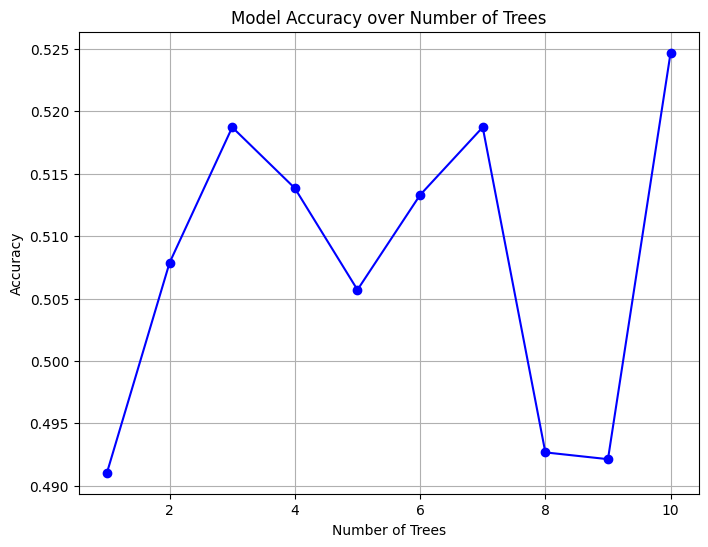

Final accuracy on test data with 10 trees: 0.5246880086814976
Top 5 Important Features:
Diastolic: 0.1332
BMI: 0.1164
Triglycerides: 0.1138
Heart Rate: 0.1063
Age: 0.0920


In [26]:


# Plot the accuracy through the iterations
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), test_accuracies, marker='o', color='b')
plt.title("Model Accuracy over Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

# Print the final accuracy
final_predictions = model.transform(data_test)
final_accuracy = evaluator.evaluate(final_predictions)
print(f"Final accuracy on test data with 10 trees: {final_accuracy}")

# Analyze feature importance
rf_model = model.stages[-1]


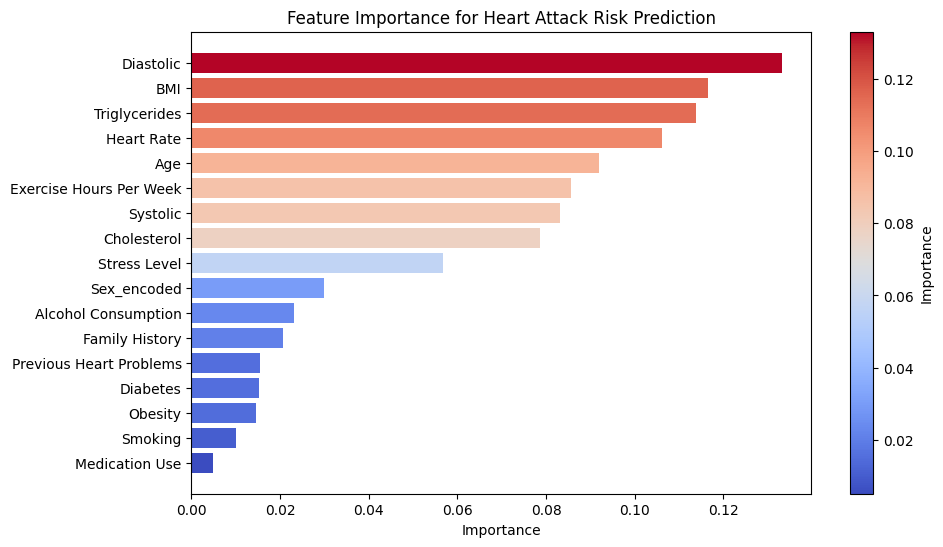

In [28]:
import matplotlib.cm as cm

feature_importance = rf_model.featureImportances

# Create a DataFrame for the feature importance
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importance.toArray()
})

# Sort by importance
importance_df = importance_df.sort_values(by="importance", ascending=False)

norm = plt.Normalize(min(importance_df['importance']), max(importance_df['importance']))
cmap = cm.coolwarm  # You can choose any other colormap like 'plasma', 'inferno', etc.

# Create a color list
colors = [cmap(norm(val)) for val in importance_df['importance']]

# Plotting with colors based on importance
fig, ax = plt.subplots(figsize=(10, 6)) # Create fig and ax explicitly
bars = plt.barh(importance_df['feature'], importance_df['importance'], color=colors)
plt.xlabel('Importance')
plt.title('Feature Importance for Heart Attack Risk Prediction')
plt.gca().invert_yaxis()  # To display the highest importance at the top

# Show the colorbar to indicate how color corresponds to importance values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, label='Importance', ax=ax) # Use fig.colorbar and specify ax

plt.show()


We can observe fluctuations in accuracy, which may indicate a lack of data in the dataset (leading to a failure to converge) or a need to adjust the model's hyperparameters.

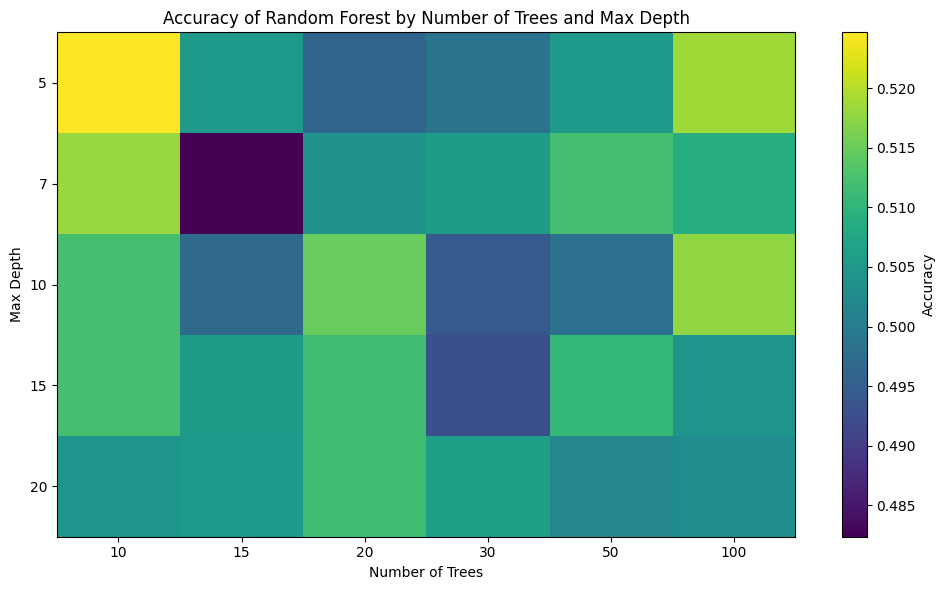

In [30]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

feature_columns = ["Age", "Cholesterol", "Heart Rate", "Diabetes", "Family History", "Smoking",
                   "Obesity", "Alcohol Consumption", "Exercise Hours Per Week", "Previous Heart Problems",
                   "Medication Use", "Stress Level", "BMI", "Triglycerides", "Systolic", "Diastolic", "Sex_encoded"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Adjustment of hyper parameters
num_trees_list = [10, 15, 20, 30, 50, 100]  # We will try to train models with different numbers of trees
max_depth_list = [5, 7, 10, 15, 20]  # Also, we will train models with different tree depths
accuracies = []

for num_trees in num_trees_list:
    for max_depth in max_depth_list:
        # Training
        rf = RandomForestClassifier(labelCol="Heart Attack Risk", featuresCol="features",
                                     numTrees=num_trees, maxDepth=max_depth, seed=42)
        pipeline = Pipeline(stages=[assembler, rf])
        model = pipeline.fit(data_train)

        predictions = model.transform(data_test)

        evaluator = MulticlassClassificationEvaluator(labelCol="Heart Attack Risk",
                                                       predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)
        accuracies.append({"num_trees": num_trees, "max_depth": max_depth, "accuracy": accuracy})

# Visualisation
results_df = pd.DataFrame(accuracies)

pivot_df = results_df.pivot(index="max_depth", columns="num_trees", values="accuracy")
plt.figure(figsize=(10, 6))
plt.imshow(pivot_df, cmap="viridis", aspect="auto")
plt.colorbar(label="Accuracy")
plt.title("Accuracy of Random Forest by Number of Trees and Max Depth")
plt.xlabel("Number of Trees")
plt.ylabel("Max Depth")
plt.xticks(range(len(num_trees_list)), num_trees_list)
plt.yticks(range(len(max_depth_list)), max_depth_list)
plt.tight_layout()
plt.show()


We clearly observe a low accuracy (around 50%) for each type of random forest classifier.

We conclude that the dataset is too small for these classifier.

<h1> XGBoost </h1>

We will try a more recent model. This model can

In [41]:
!pip install xgboost

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import xgboost as xgb
import matplotlib.pyplot as plt

# Initialize SparkSession
spark = SparkSession.builder.appName("XGBoost_PySpark").getOrCreate()

# Assemble features into a single vector
feature_columns = ["Age", "Cholesterol", "Heart Rate", "Diabetes", "Family History", "Smoking",
                   "Obesity", "Alcohol Consumption", "Exercise Hours Per Week", "Previous Heart Problems",
                   "Medication Use", "Stress Level", "BMI", "Triglycerides", "Systolic", "Diastolic", "Sex_encoded"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
if 'features' not in data.columns:
    dataBoost = assembler.transform(data)

# Split the data into train and test sets
data_train, data_test = dataBoost.randomSplit([0.7, 0.3], seed=42)

data_train = data_train.select("features", "Heart Attack Risk")
data_test = data_test.select("features", "Heart Attack Risk")


# Convert data to XGBoost DMatrix
train_features = data_train.select("features").rdd.map(lambda x: x[0].toArray()).collect()
train_labels = data_train.select("Heart Attack Risk").rdd.flatMap(lambda x: x).collect()

test_features = data_test.select("features").rdd.map(lambda x: x[0].toArray()).collect()
test_labels = data_test.select("Heart Attack Risk").rdd.flatMap(lambda x: x).collect()

train_dmatrix = xgb.DMatrix(data=train_features, label=train_labels)
test_dmatrix = xgb.DMatrix(data=test_features, label=test_labels)

# Train XGBoost model
params = {
    "objective": "binary:logistic",
    "max_depth": 5,
    "eta": 0.1,
    "eval_metric": "logloss",
    "seed": 42
}
num_rounds = 100

eval_set = [(train_dmatrix, "train"), (test_dmatrix, "test")]
eval_results = {}

# Train XGBoost model and store evaluation results
bst = xgb.train(params, train_dmatrix, num_rounds, evals=eval_set, evals_result=eval_results)

# Plot training and test accuracy
epochs = range(len(eval_results["train"]["logloss"]))



[0]	train-logloss:0.68978	test-logloss:0.69286
[1]	train-logloss:0.68698	test-logloss:0.69292
[2]	train-logloss:0.68368	test-logloss:0.69325
[3]	train-logloss:0.68150	test-logloss:0.69328
[4]	train-logloss:0.67815	test-logloss:0.69344
[5]	train-logloss:0.67624	test-logloss:0.69351
[6]	train-logloss:0.67406	test-logloss:0.69384
[7]	train-logloss:0.67175	test-logloss:0.69402
[8]	train-logloss:0.66900	test-logloss:0.69423
[9]	train-logloss:0.66622	test-logloss:0.69378
[10]	train-logloss:0.66435	test-logloss:0.69382
[11]	train-logloss:0.66244	test-logloss:0.69387
[12]	train-logloss:0.66045	test-logloss:0.69430
[13]	train-logloss:0.65827	test-logloss:0.69461
[14]	train-logloss:0.65663	test-logloss:0.69514
[15]	train-logloss:0.65283	test-logloss:0.69589
[16]	train-logloss:0.65110	test-logloss:0.69686
[17]	train-logloss:0.64807	test-logloss:0.69687
[18]	train-logloss:0.64721	test-logloss:0.69697
[19]	train-logloss:0.64398	test-logloss:0.69762
[20]	train-logloss:0.64259	test-logloss:0.69804
[2

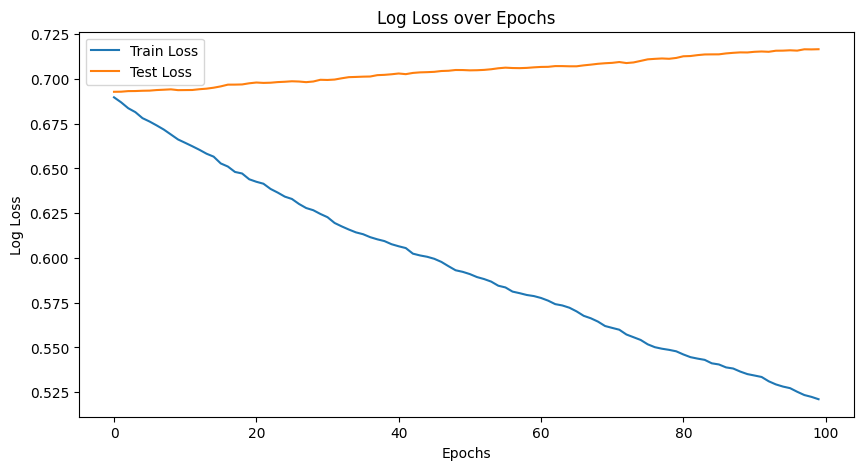

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_results["train"]["logloss"], label="Train Loss")
plt.plot(epochs, eval_results["test"]["logloss"], label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Log Loss over Epochs")
plt.legend()
plt.show()

We can observe that this model is also overfitting.

Again, this might be the lack of data in the dataset.

<h1> Using sklearn module, let's find the fittest type of model.

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

models=[LogisticRegression(max_iter=500),SVC(),DecisionTreeClassifier(),RandomForestClassifier(),GaussianNB(),KNeighborsClassifier(),MLPClassifier()]
model_names=["Logistic Regression","Support Vector Machine","Decision Tree","Random Forest","Gaussian Naive Bayes","K-Nearest Neighbors","Multi Layer Perceptron"]
models_scores=[]

# Convert PySpark DataFrames to pandas DataFrames
X_train_pd = X_train.toPandas()
y_train_pd = y_train.toPandas()
X_test_pd = X_test.toPandas()
y_test_pd = y_test.toPandas()

# you can also convert y_train_pd['Heart Attack Risk'] to a 1D numpy array using .values if needed for some models
y_train_pd = y_train_pd['Heart Attack Risk'].values # optional step for models that require 1D target arrays

#y_test_pd = y_test_pd['Heart Attack Risk'].values # optional step for models that require 1D target arrays

for model,model_name in zip(models,model_names):
    # Fit using the converted pandas DataFrames
    model.fit(X_train_pd,y_train_pd)
    y_pred=model.predict(X_test_pd)
    accuracy=accuracy_score(y_test_pd['Heart Attack Risk'].values,y_pred)
    models_scores.append([model_name,accuracy])
sorted_models_scores=sorted(models_scores,key=lambda x:x[1],reverse=True)
for model in sorted_models_scores:
    print("Accuracy Score: ",f'{model[0]}: {model[1]*100:.2f}')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score:  Gaussian Naive Bayes: 52.69
Accuracy Score:  K-Nearest Neighbors: 52.63
Accuracy Score:  Logistic Regression: 51.98
Accuracy Score:  Support Vector Machine: 51.33
Accuracy Score:  Multi Layer Perceptron: 51.06
Accuracy Score:  Decision Tree: 50.73
Accuracy Score:  Random Forest: 49.21


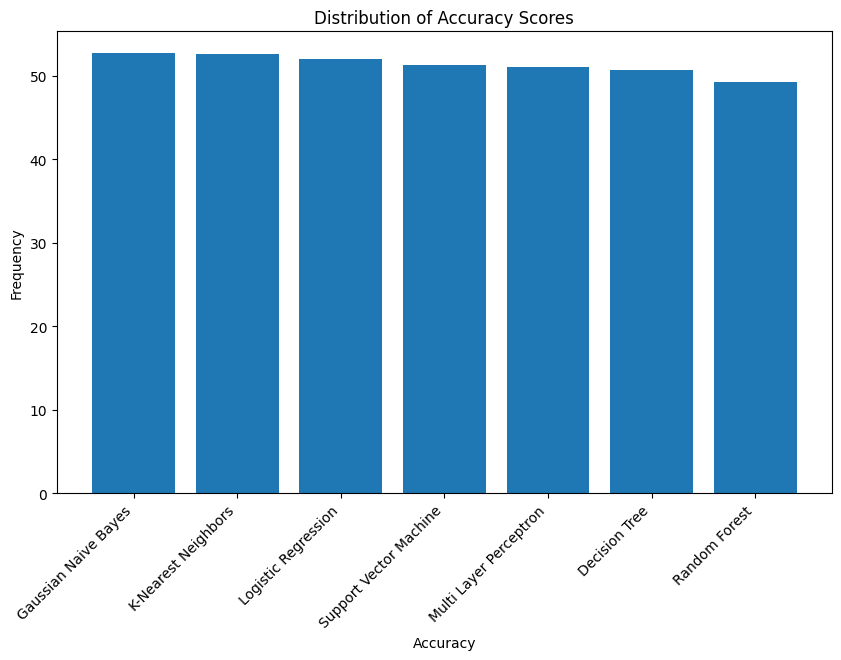

In [53]:
accuracies = [model[1]*100 for model in sorted_models_scores]
model_names = [model[0] for model in sorted_models_scores]
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Accuracy Scores')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

<h1> Final Conclusion : </h1>

We can clearly see that none of the models is able to reach a reliable accuracy.

What we could do is to use oversampling to create artificial data to create a solid database for CNN models training.